In [28]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Introduction

Recently neural networks (NN) have found a vast application in various high stakes domains, e.g. automotive, biomedical industry, etc. Yet, due to their complex and often convoluted structure, we usually lack an understanding of their decision-making. One possible approach to this issue would be to utilize the predictive uncertainty of NNs. However, a question arises whether the latter reflects the real situation and can thus be trusted. Consequently, this work explores the notion of calibrated uncertainty as well as methods to achieve it.

Firstly, we justify the importance of NNs returning reliable confidence values. Secondly, we outline the reasons why this behaviour is expected from NNs. Next, we explore what can go wrong with the calculation of confidence values from a mathematical point of view. Some methods to measure and visualize a NN's calibration are described and implemented afterwards. We then describe an observed trend of overconfidence in modern NNs as well as the most probable reasons behind it.

Moreover, we take this observation as a premise to perform our own experiments. Hence, we measure and visualize the calibration of the well-known model ResNet with 101 layers, and implement temperature scaling as one of the most popular calibration methods. The latter technique produced better calibrated outputs preventing the initial overconfidence of our network.

Finally, we tested the performance of temperature scaling with out-of-distribution data (ODD). Since this trial proved the ineffectiveness of temperature scaling under these conditions, we briefly explain different calibration methods which can cope with such situations, such as deep ensembles and the Monte Carlo Dropout.

# Intuition behind Calibration

In the beginning we want to build up an intuitive perspective on the calibration of NNs. To do that, we have to define two key concepts:

The **accuracy of a neural network** is the rate of its correct classifications.

The **confidence of a neural network's prediction**  is the calculated probability that the corresponding prediction is correct.

The **calibration of a neural network** is a term that describes how accurately the NN can calculate the **confidence** for its predictions. In other words, if a NN calculates that its prediction is correct with a certain probability, the calibration of the NN indicates how much this given probability can be trusted.

Additionally, some signs pointing at a well-calibrated NN are as follows: 

* the accuracy of the NN is roughly equal to its average confidence;
* given a set of predictions with similar confidence, the average accuracy and the average confidence of the NN on these predictions should be approximately equal to one another; 
* predictions of the NN for nonsensical inputs have low confidence values.



# Importance of Calibration

Often, in real-life applications of NNs, it is not only important how a NN classifies certain data but also how confident the NN is about its classification. In the latter case, the NN needs to return reliable confidence values; this means it has to be well-calibrated.

An example of such a scenario would be a NN used in a self-driving car that detects obstacles on the road. If an obstacle on the road is detected, the NN should be confident of its prediction. Otherwise, it should rely on other sensors so that it does not, for example, falsely trigger emergency braking, which could endanger the surrounding traffic.

Another instance would be a NN utilized for disease diagnosis, which should pass on the task to a human doctor if the confidence of its diagnosis is low. Therefore, in certain applications of a NN, the latter must be well-calibrated. 

# Why Should a Neural Network Return Reliable Confidence Values?

## A Mathematical Point of View on Neural Networks

From a mathematical point of view, a trained NN is basically a conditional probability distribution $\mathbb{Q}(y|x)$. The input variables to this probability distribution are a datapoint $x \in \mathbb{R}^n$, which can, for example, be a vector representation of an image, and a label $y \in \{1,...,n\}$ representing a certain class. A prediction of a NN for a datapoint $x$, denoted by $Pre(x)$, is a label maximizing the probability distribution $\mathbb{Q}(y|x)$, i.e.
$$ Pre(x) = argmax_{y \in \{1,..,n\}} \mathbb{Q}(x|y). $$

The confidence of a NN that a certain datapoint $x \in \mathbb{R}$ has a label $y \in \{1,...,n\}$ is given by
$$ Conf(x,y) = \mathbb{Q}(y|x).$$

## Probabilistic Aspect of Neural Network's Learning Procedure

The probability distribution which corresponds to a NN has to be learned. This is achieved by training a NN using a dataset $(x_i,y_i)_{i\in\{1,...,n\}}$ with known labels $(y_i)_{ i \in \{1,...,n\}}$. This dataset is distributed according to an underlying probability distribution $\mathbb{P}$ from a family of probability distributions $\mathbf{P}$:
$$(x_i,y_i)_{i\in\{1,...,n\}} \sim  \mathbb{P} \in \mathbf{P} $$
Thus, the goal of training a NN is to approximate the underlying probability distribution $\mathbb{P}$, that produced the given dataset, with a probability distribution $\mathbb{Q}$ from the family of probability distributions $\mathbf{Q}$; the latter includes all probability distributions that can be captured by the structure of the NN. For the approximation, we can use the negative log-likelihood function 
$$L_{x}(\mathbb{Q},y) = -\log(\mathbb{Q}(y|x)), $$
for which the following equation can be shown:
$$ \mathbb{Q} = \text{argmin}_{\mathbb{Q}\in \mathbf{P}} \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) ) \Rightarrow \mathbb{Q} = \mathbb{P}. $$

This means that if we retrieve the probability distribution $\mathbb{Q}\in \mathbf{P}$, that minimizes $\mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) )$, the expected value of the negative log-likelihood function, then the probability distribution $\mathbb{P} \in \mathbf{P}$ underlying the data is determined.

But there are problems with that approach; since the underlying probability distribution $\mathbb{P} \in \mathbf{P}$ is unknown, the expected value can not be calculated directly. Hence, its approximation has to be used to find a minimizing distribution $\mathbb{Q} \in \mathbf{Q}$.
We use a training dataset $(x_i,y_i)_{i\in\{1,...,n\}}$ to approximate the expected value of the negative log-likelihood as follows: 
$$L(\mathbb{Q})=\sum_{i=1}^{n} -\log(\mathbb{Q}(y_i|x_i))=\sum_{i=1}^{n} L_{x_i}(\mathbb{Q},y_i) \approx \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) ). $$
That is to say, during the training of a NN, a numerical algorithm finds a probability distribution $\mathbb{Q} \in \mathbf{Q}$ minimizing the function $L$, which approximates the expected value of the negative log-likelihood:
$$ \mathbb{Q} \approx \text{argmin}_{\mathbb{Q}\in\mathbf{Q}} L(\mathbb{Q}) \approx \text{argmin}_{\mathbb{Q} \in \mathbf{P}} \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) )=\mathbb{P}.$$

## Reliable Confidence Values

Given two probability distributions $\mathbb{Q} \in \mathbf{P}$, $\mathbb{P} \in \mathbf{P}$  and the negative log-likelihood function
$$ L_{x}(\mathbb{Q},y) = -\log(\mathbb{Q}(y|x)), $$
it can be shown that 
$$ \mathbb{Q} = \text{argmin}_{\mathbb{Q}\in \mathbf{P}} \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) ) \Rightarrow \mathbb{Q} = \mathbb{P}. $$

Since $\mathbb{P} \in \mathbf{P}$ is the probability distribution
that underlies the sample data, the confidence values returned
by $\mathbb{P}$ are reliable by the very definition of $\mathbb{P}$.
As we saw in the previous section,
by training the NN, we find a probability distribution $\mathbb{Q} \in \mathbf{Q}$ satisfying 
$$ \mathbb{Q} \approx \text{argmin}_{\mathbb{Q}\in\mathbf{Q}} L(\mathbb{Q}) \approx \text{argmin}_{\mathbb{Q} \in \mathbf{P}} \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) ) = \mathbb{P}.$$

Thus, since $\mathbb{Q} = \text{argmin}_{\mathbb{Q}\in \mathbf{P}} \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) ) \Rightarrow \mathbb{Q} = \mathbb{P}$ and
$\mathbb{Q} \approx \text{argmin}_{\mathbb{Q} \in \mathbf{P}} \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) )$, our probability distribution $\mathbb{Q} \in \mathbf{Q}$ is 
designed to approximate the probability distribution $\mathbb{P} \in \mathbf{P} $ that underlies the data.
As a result, the confidence values given by the NN should be reliable. 

# What Can Go Wrong?

There are multiple ways in which the above mentioned method can go wrong so that a NN does not output trustworthy confidence. Hence, we find the minimizing probability distribution $\mathbb{Q}$ with a numerical algorithm, which could converge to a probability distribution that represents a local minimum of the function $L$ and not the global minimum. However, if the numerical algorithm converges to a distibution $\mathbb{Q}$ that displays the global minimum of the error function, then the error function itself is only an approximation for the expression 
$$ \mathbb{E}_{\mathbb{P}} (L_{x}(\mathbb{Q},y) ) .$$
Its quality is highly dependent on the sample data. Moreover, the underlying distribution $\mathbb{P}$ can not always be properly approximated by a probability distribution $\mathbb{Q} \in \mathbf{Q}$ , since the family $\mathbf{Q}$ is restricted by the structure of the NN.

# Calibration Measurements

There are multiple ways to measure the calibration of NNs; they can be divided into scalar and graphical approaches.

For $i \in \{1,..,n\}$ let $\hat{y}_i$ be a prediction of a NN for a datapoint $x_i$ with a true label $y_i$ and an associated confidence value $conf_i$.
Based on the confidence values $conf_i$, we can distribute the indices of the predictions into $M$ interval bins $(B_m)_{m \in \{0,...,M-1\}}$, defined as follows:
$$ B_m = \left\{i|\frac{m}{M} \leq conf_i < \frac{m+1}{M} \right\}.$$
For these bins $B_m$, we can now calculate the accuracy and average confidence as follows:
$$ acc(B_m) = \frac{1}{|B_m|}\sum_{i\in B_m} 1(\hat{y_i}=y_i) $$
$$ conf(B_m) = \frac{1}{|B_m|}\sum_{i\in B_m} conf_i .$$

Based on the above, one may consider the following scalar calibration measurements:
1. The expected calibration error: 
$$ ECE = \sum_{m=0}^{M} \frac{|B_m|}{n} (acc(B_m)-conf(B_m)). $$
2. The maximum calibration error: 
$$ MCE = \max_{m\in \{0,...,M\}} |acc(B_m)-conf(B_m)|. $$

Similarly, the visualisation of a NN's calibration also involves interval bins. One often considers a so-called *reliability diagram*, which is a bar diagram where the x- and y-axis depict the confidence divided into bins and the accuracy of a corresponding bin, respectively. 


# Miscalibration of Modern NNs

The calibration of NNs is a crucial part of their safe usage, however, the calibration quality is lower in modern NNs, while the accuracy of the classifications is higher. For example, the below reliability diagram displays that the confidence of [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
closely approximates its expected accuracy, whereas
[ResNet's](https://arxiv.org/abs/1512.03385)
accuracy does not match its confidence [GPSW17].

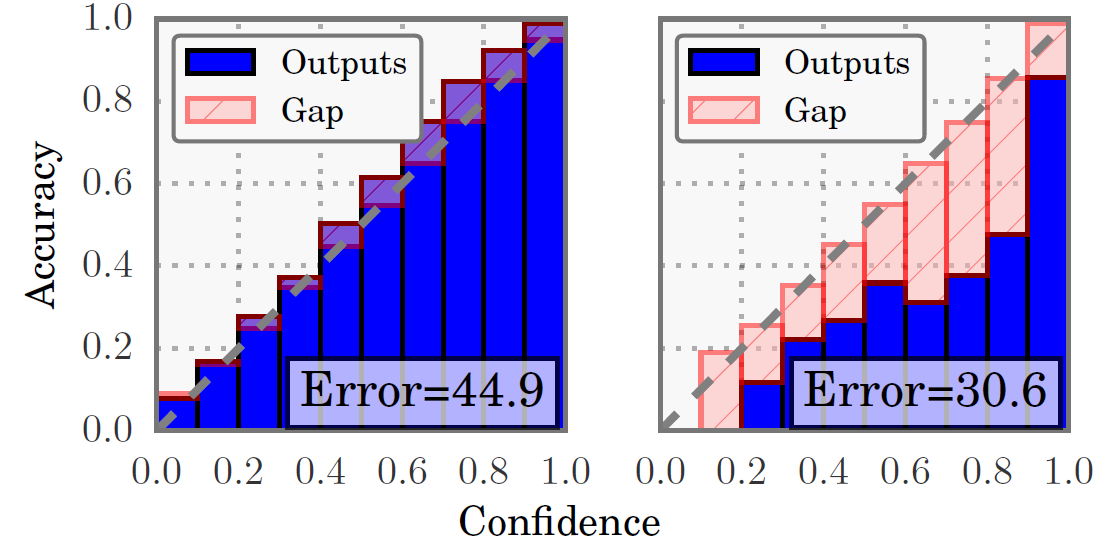


# Project Set-up

The goal of this work is to investigate the problem of miscalibration of modern NNs. In order to achieve this, we chose to work with ResNet, a well-known model for object classification, as well as 
[Cifar-100](https://www.cs.toronto.edu/~kriz/cifar.html)
as a dataset.

We then measured the calibration of our model by implementing scalar approaches such as *ECE*, *MCE* and visual methods like reliability diagrams with confidence histograms. Apart from that, we implemented temperature scaling as a possible method to tackle the issue of miscalibration and investigated its application to the out-of-distribution data (ODD).

## Dependencies

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math 

from tqdm.notebook import tqdm as tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Global Variables

In [31]:
# Mean and standard deviation of the ImageNet dataset.
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

# Hyperparameters for training procedure.
batchsize = 128
NUM_EPOCHS = 50

In [32]:
# Use cuda if available, otherwise use cpu.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make code reproducible.
torch.manual_seed(42)
np.random.seed(42)

# Dataset

Cifar-100 contains natural images of size $32 \times 32$ pixels (see Figure below). There are overall 100 classes, each containing 600 images. Moreover, Cifar-100 provides 500 training images and 100 testing images per class [Kri].

## Constuct datasets and dataloaders

In [33]:
# Normalize the images by the ImagenŃet mean and standard deviation since the network is pretrained.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std)])

# Download a training set of Cifar100.
dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

# Split the training dataset into a training and validation set.
train_set, val_set = torch.utils.data.random_split(dataset, [45000, 5000])

# Create dataloaders for the training and validation set.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize,
                                          shuffle=True, num_workers=2)


val_loader = torch.utils.data.DataLoader(val_set, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

# Download a test set of Cifar100.
test_set = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
# Create dataloaders for the test set.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Visualize dataset

In [34]:
# Create a dataloader for a training set of Cifar 100 without normalization required for
# a network pretrained on the ImageNet.
transform = transforms.Compose(
    [transforms.ToTensor()])

dset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

dset_loader = torch.utils.data.DataLoader(dset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)



Files already downloaded and verified


In [35]:
def show_batch(dl):
"""
This function visualizes the images of the given dataloader in a grid.
Args:
  dl: dataloader.
"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title('Figure 2:  Example of the images in the dataset Cifar-100.', fontsize=14)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        plt.savefig("/content/drive/MyDrive/Calibration/plots/dataset.jpeg",
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.5)
        break


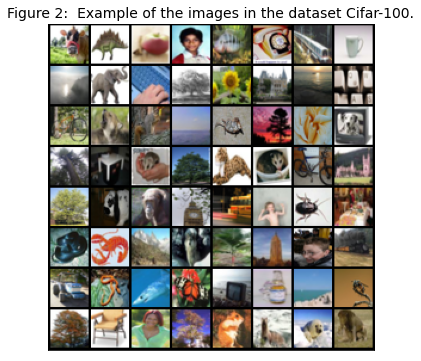

In [36]:
show_batch(dset_loader)

# Model and Training Procedure

For our experiments, we used ResNet with 101 layers provided from the package [torchvision.models](https://pytorch.org/vision/stable/models.html). To reduce the training time, we chose a model pretrained on [ImageNet](https://pytorch.org/vision/stable/models.html), which is a dataset of natural images with 1000 classes. To improve the accuracy on Cifar-100, we finetuned our models, which means updating all parameters of the model. The best results were achieved using SGD with a learning rate $0.05$, momentum $0.9$ and $200$ epochs. The accuracy eventually reached around $61.8 \%$ on a test set for ResNet-101.

## ResNet

In [37]:
# Use a pretrained ResNet with 101 classes from the package torchvision.models.
# Map the last layer to the number of classes of Cifar 100 using a fully connected layer.
num_classes = 100
net = models.resnet101(pretrained=True)
net.fc = nn.Linear(2048, num_classes)
net = net.to(device)

In [38]:
# Load weights from the best model which was learnt.
state_dict = torch.load('./ResNet.pkl')
net.load_state_dict(state_dict)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train

In [39]:
def train(net = net, num_epochs = NUM_EPOCHS):
"""
This function trains a given network.
It also saves a model, which has the best accuracy on the validation set.
Args:
  net: a network to train;
  num_epochs: number of epochs to train a network.
"""
  best_acc = 0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.005, momentum = 0.9)

  for epoch in range(num_epochs):

      running_loss = 0.0
      net.train()
      print('Training iteration {:d}'.format(epoch))
      for i, (images, labels) in enumerate(tqdm(train_loader, 0)):

          images = images.to(device)
          labels = labels.to(device)
        
          optimizer.zero_grad()

          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
        
      corrects = []
      net.eval()
      classified_right = 0
      print('Evaluating on validation set')
      for i, (images, labels) in enumerate(tqdm(val_loader, 0)):
          with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, pred_classes = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            classified_right += (pred_classes == labels).sum().item()
          
      acc = classified_right / len(val_set)
      if acc > best_acc:
        best_acc = acc
        torch.save(net.state_dict(), '/content/drive/MyDrive/Calibration/weights/ResNet.pkl')
      print('Epoch {:d}  Acc: {:2f}'.format(epoch, acc))


## Test

In [40]:
def test(net = net, T_scaling=None, temperature = None):
"""
This function computes the average accuracy of a given network.
Args:
  net: a trained network which accuracy has to be computed;
  T_scaling: function to normalize logits by the given temperature value;
  temperature: computed temperature value.
"""
  correct = 0
  net.eval()
  with torch.no_grad():
      for images, labels in tqdm(test_loader):
          images = images.to(device)
          labels = labels.to(device)

          logits = net(images)
          
          if T_scaling:
            logits = T_scaling(logits, temperature)

          softmax = nn.Softmax(dim=1)
          pred = softmax(logits)

          _, predicted_classes = torch.max(pred.data, 1)
          pred = pred.cpu().detach().numpy()

          correct += sum(predicted_classes == labels).item()

  correct_percentage= correct / len(test_set)
  print('Accuracy of the network on the 10000 test images: {:2f}'.format(100 * correct_percentage))

In [41]:
# Compute the average accuracy of the finetuned ResNet 101.
test()

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 61.770000


# Function definitions

#### getLogitsAndLabels

In [42]:
def getLogitsAndLabels(loader, net = net):
"""
This function computes the logits produced by a given model on a given dataloader.
It returns a list of logits and labels.
Args:
  loader: dataloader which images have to be processed;
  net: a trained network.
Returns:
  a list of logits and a list of labels.
"""
  logits_list = []
  labels_list = []
  with torch.no_grad():
    net.eval()

    for images, labels in tqdm(loader):
      images = images.to(device)
      labels = labels.to(device)
      logits = net(images)

      logits_list.append(logits)
      labels_list.append(labels)
    logits = torch.cat(logits_list).to(device)
    labels = torch.cat(labels_list).to(device)
    return logits, labels

#### T_scaling

In [43]:
def T_scaling(logits, temperature):
"""
This function normalizes given logits with a given temperature.
Args:
  logits: a list of logits which have to be normalized;
  temperature: temperature value.
Returns:
  logits divided by temperature
"""
  return torch.div(logits, temperature)

#### plot_tempreture_scaling

In [44]:
def plot_tempreture_scaling(tempature_list, losses_list):
"""
This function visualizes a process of temperature optimization.
Args:
  tempature_list: a list of temperature values obtained during optimization of temperature;
  losses_list:  a list of losses associated with the process of finding an optimal temperature value.
"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.8)

    ax1.plot(tempature_list, '-r')
    ax1.set_title('Temperature vs. epoch')
    ax1.set(xlabel='Epoch', ylabel='Temperature')
    ax1.set_xticks([0, 50, 100, 150, 200])
    ax1.grid()

    ax2.plot(losses_list, '-r',)
    ax2.set_title('Loss vs. epoch')
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.set_xticks([0, 50, 100, 150, 200])
    ax2.grid()
    
    plt.savefig("./plots/tempreture_scaling.jpeg",
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.5)
    plt.show()

#### tempreture_scaling

In [45]:
def tempreture_scaling(logits_list, labels_list):
"""
This function finds optimal temperature values based on the provided logits and corresponding labels.
Args:
  logits_list: a list of logits;
  labels_list: a list of corresponding labels.
Returns:
  the optimal temperature value, lists of all temperature values and losses produced during the optimization process.
"""
  temperature = nn.Parameter(torch.ones(1).cuda())
  criterion = nn.CrossEntropyLoss()

  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

  temps = []
  losses = []

  def _eval():
    loss = criterion(T_scaling(logits_list, temperature), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss

  optimizer.step(_eval)

  print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

  return temperature.item(), temps, losses

#### calculateScalarCalibrationErrors
   

In [46]:
def calculateScalarCalibrationErrors(logits, labels, n_bins=10):
"""
This function calculates the expected calibration error (ECE) and maximum calibration error (MCE).
Args:
  logits: a list of logits;
  labels:  a list of corresponding labels.
Returns:
  the ECE and MCE.
"""
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)

    mce = 0
    ece = torch.zeros(1, device=logits.device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            if (mce < torch.abs(avg_confidence_in_bin - accuracy_in_bin)):
              mce = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
    return ece.item(), mce.item()

#### makeModelDiagrams

In [47]:
def makeModelDiagrams(logits, labels, n_bins=10):
"""
This function plots the reliability diagram and confidence histogram.
Args:
  logits: a list of logits;
  labels:  a list of corresponding labels;
  n_bins: number of bins for the reliability diagram and confidence histogram.
"""    
    softmaxes = torch.nn.functional.softmax(logits, 1)
    confidences, predictions = softmaxes.max(1)
    accuracies = torch.eq(predictions, labels)
    overall_accuracy = (predictions==labels).sum().item()/len(labels)
    
    bins = torch.linspace(0, 1, n_bins + 1)
    width = 1.0 / n_bins
    bin_centers = np.linspace(0, 1.0 - width, n_bins) + width / 2
    bin_indices = [confidences.ge(bin_lower) * confidences.lt(bin_upper) for bin_lower, bin_upper in zip(bins[:-1], bins[1:])]

    bin_corrects = np.array([ torch.mean(accuracies[bin_index].float()) for bin_index in bin_indices])
    bin_scores = np.array([ torch.mean(confidences[bin_index].float()) for bin_index in bin_indices])
    bin_num_predictions = np.array([ torch.sum(confidences[bin_index].float()) for bin_index in bin_indices])
    bin_corrects[bin_corrects != bin_corrects] = 0
    bin_scores[bin_scores != bin_scores] = 0
    bin_num_predictions[bin_num_predictions != bin_num_predictions] = 0
       
    plt.figure(0, figsize=(8, 8))
    gap = (bin_scores - bin_corrects)
 
    confs = plt.bar(bin_centers, bin_corrects, width=width, alpha=0.1, ec='black')
    gaps = plt.bar(bin_centers, (bin_scores - bin_corrects), bottom=bin_corrects, color=[1, 0.7, 0.7], alpha=0.5, width=width, hatch='//', edgecolor='r')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.legend([confs, gaps], ['Outputs', 'Gap'], loc='best', fontsize=18)

    plt.ylabel("Accuracy", size=18)
    plt.xlabel("Confidence", size=18)
    plt.xlim(0,1)
    plt.ylim(0,1.01)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig('/content/drive/MyDrive/Calibration/plots/reliability_ResNet_101_rotation_scaled_1.png', bbox_inches='tight')
    plt.show()

    plt.plot(np.linspace(0, 1, n_bins), bin_corrects)
    plt.scatter(np.linspace(0, 1, n_bins), bin_corrects, color='red')
    plt.xlabel("Confidence", size=18)
    plt.ylabel("Accuracy", size=18)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig('/content/drive/MyDrive/Calibration/plots/reliability_ResNet_101_rotation_scaled_2.png', bbox_inches='tight')
    plt.show()

    plt.bar(bin_centers, bin_num_predictions, width=width, alpha=0.1, ec='black')
    plt.xlabel("Confidence", size=18)
    plt.ylabel("Number of predictions", size=18)
    plt.xlim(0,1)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig('/content/drive/MyDrive/Calibration/plots/histogram_ResNet_101_rotation_scaled.png', bbox_inches='tight')
    plt.show()

    plt.pause(0.05)
    
    ece, mce  = calculateScalarCalibrationErrors(logits, labels)
    print('Overall accuracy: {:.2f} %'.format(overall_accuracy * 100))
    print('Expected Calibration Error: {:.2f}'.format(ece))
    print('Maximum Calibration Error: {:.2f}'.format(mce))

# Experiments

## Calibration Measurements for ResNet-101

First of all, we attempted to measure the calibration of ResNet-101 using the methods described above. As expected, *ECE* and *MCE* are quite high, namely, $27 \%$ and $50 \%$, respectively. Moreover, it is evident from the confidence histogram that the largest portion of predictions falls into the last bin. Additionally, this bin corresponds to a fairly high deviation from the diagonal on the reliability diagram. Indeed, our model is not well-calibrated after the training procedure.

  0%|          | 0/79 [00:00<?, ?it/s]

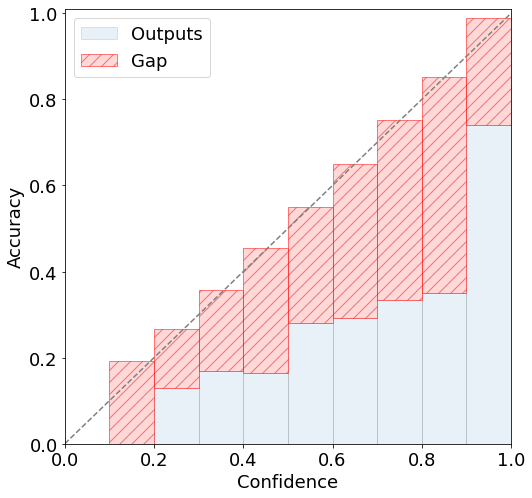

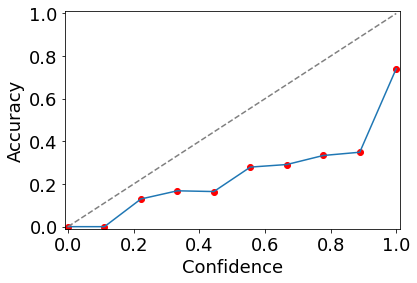

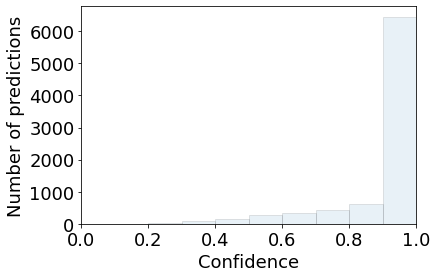

Overall accuracy: 61.77 %
Expected Calibration Error: 0.27
Maximum Calibration Error: 0.50


In [48]:
# Compute and visualize calibration errors before applying temperature scaling.
logits_list, labels_list = getLogitsAndLabels(test_loader)
makeModelDiagrams(logits_list, labels_list)

## Temperature Scaling

### Idea and Implementation

Next, we decided to implement one of the most well-known calibration methods called *temperature scaling*. It is a post-processing approach, which means it is applied after a training procedure is finished. Moreover, it requires a hold-out validation set, which must be drawn from the same distribution as the training set [GPSW17].
 
 One if the main advantages of *temperature scaling* is its simplicity and effectiveness in various scenarios. The idea behind this technique is to learn a single scalar $T > 0$, where $T$ is the *temperature*, to rescale logit scores before applying the softmax function. An optimal $T$ is found by minimizing the negative log likelihood for a held-out validation dataset  [awsc].
 
After $T$ is extracted, the new probability for class $j$  given the logit vector $z_i$ for prediction $i$, is computed as follows:
 $$
  Conf(y_i=j)=\frac{\exp(\frac{z_i^{(j)}}{T})}{\sum_{k = 1}^{K}\exp(\frac{z_i^{(k)}}{T})}.
 $$
 
  Since the same $T$ is used for all classes, temperature scaling does not change the maximum of the softmax function. As a result, *temperature scaling* does not affect the model's accuracy [GPSW17].
  
  Moreover, in overconfident models with $T>1$, the recalibrated probabilities have a lower value than the original probabilities, and they are more evenly distributed between 0 and 1 [awsc].
  
In order to learn the optimal temperature for our trained model, we utilized the same dataset used for hyperparameter tuning, which contained $5000$ images. As described above, we used cross-entropy loss applied to scaled logits and labels. Apart from that, we decided to use an LBFGS optimizer with a learning rate of $0.001$ and maximum iterations of $10000$. Finally, the optimal temperature for our model turned out to be - $2.56$, conforming to the initial overconfidence of our model.

To verify the effectiveness of *temperature scaling*, we measured the calibration after dividing logits by the temperature value determined. Indeed, *ECE* and *MCE* dropped from $27 \%$ and $50 \%$ to $3\%$ and $11 \%$, respectively. The same behaviour can be observed on the reliability diagram, which displays a much smaller deviation from the diagonal.

  0%|          | 0/40 [00:00<?, ?it/s]

Final T_scaling factor: 2.56


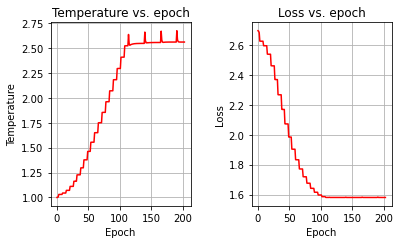

  0%|          | 0/79 [00:00<?, ?it/s]

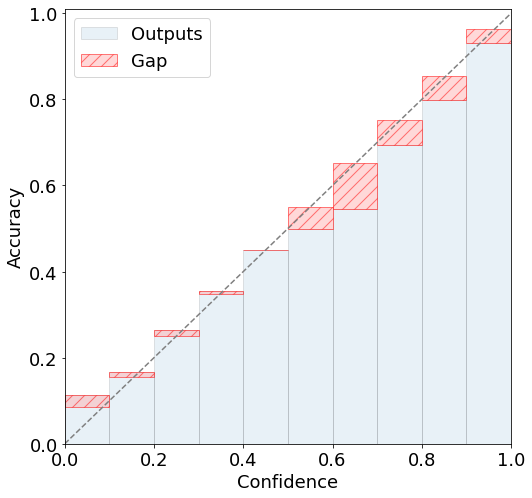

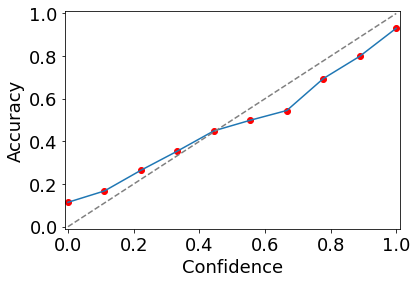

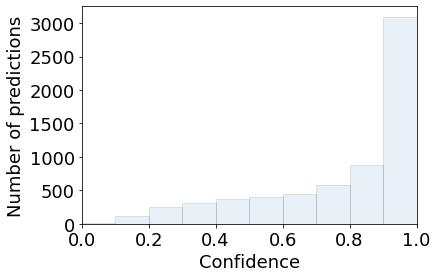

Overall accuracy: 61.77 %
Expected Calibration Error: 0.03
Maximum Calibration Error: 0.11


In [49]:
# Find optimal temperature value.
# After that, compute and visualize calibration errors after applying temperature scaling.
logits_list, labels_list = getLogitsAndLabels(val_loader)
temperature, temps , losses = tempreture_scaling(logits_list, labels_list)
plot_tempreture_scaling(temps, losses)
logits, labels = getLogitsAndLabels(test_loader)
makeModelDiagrams(T_scaling(logits, temperature), labels)

### Performance with Data Shift

However, *temperature scaling* is not robust in capturing epistemic uncertainty with ODD data [OFR+19]. To investigate this problem, we produced a data shift by rotating a test set clockwise and measuring calibration for each angle from $0$ to $180$ degrees with the step $10$. Consequently, the highest calibration error was associated with a test set rotated to $130$ degrees (see Fig. below). After that, we divided the logits with the previously found temperature value. As expected, calibration errors were still quite high, namely, *ECE* and *MCE* were $24 \%$ and $52 \%$, respectively.
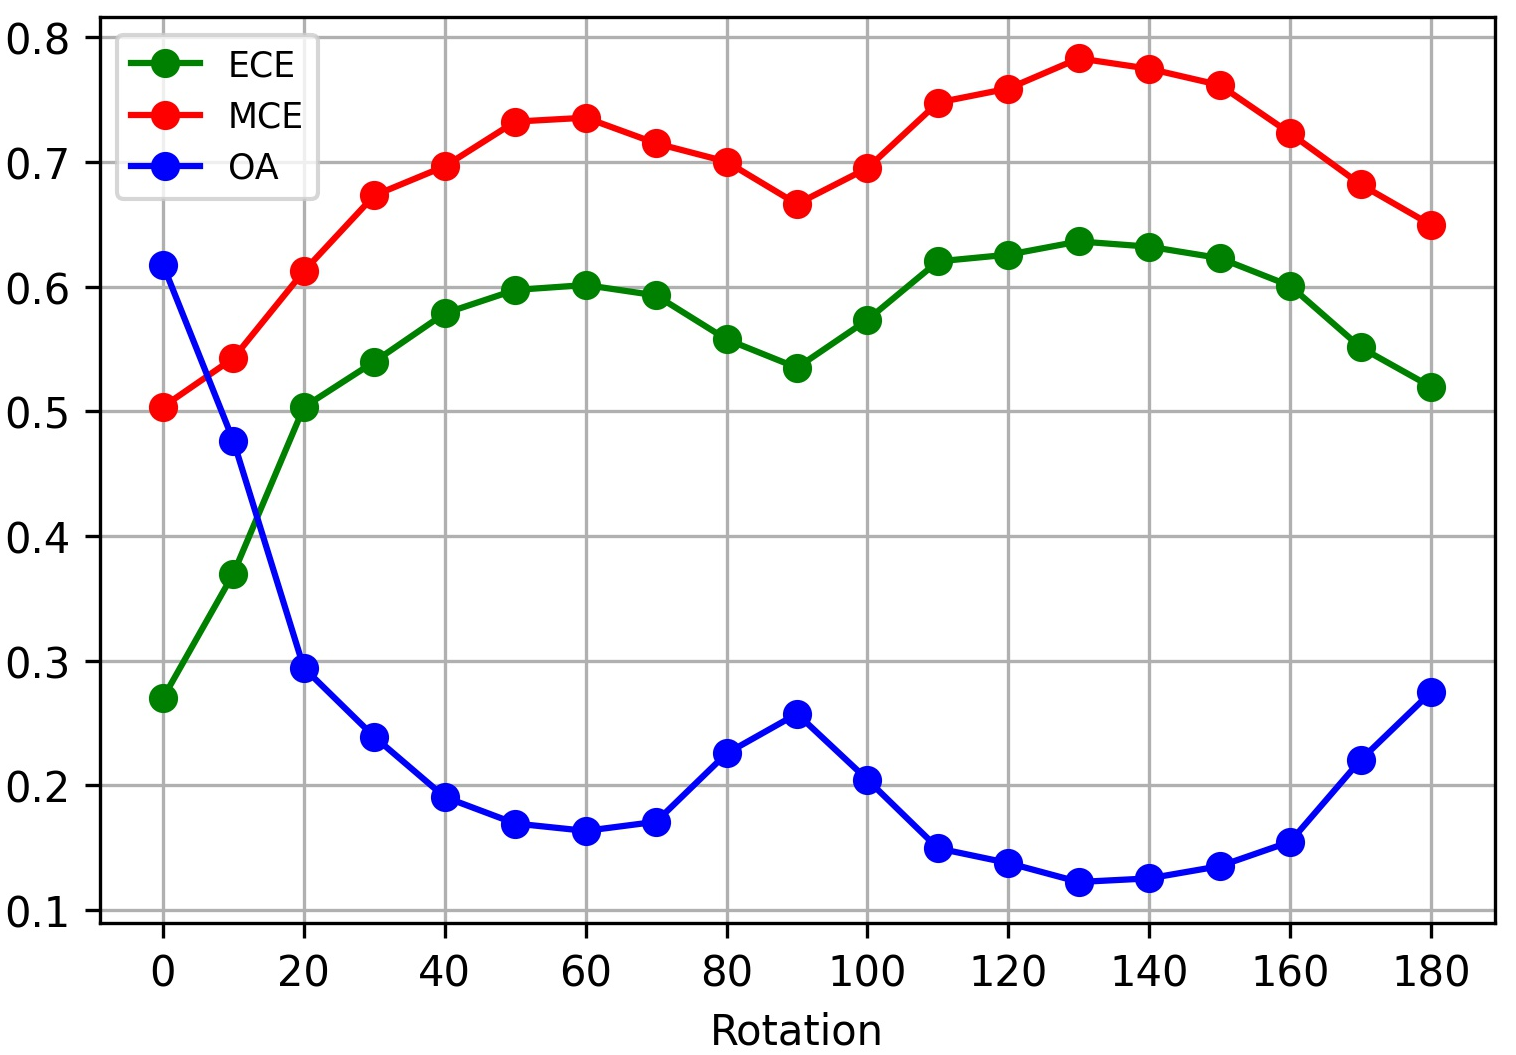

Files already downloaded and verified


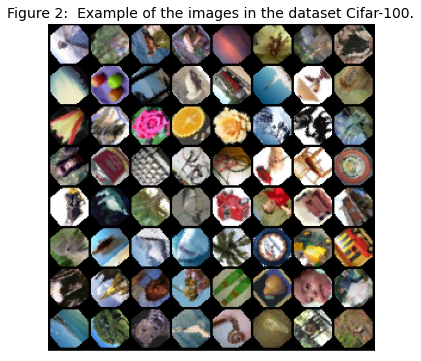

In [50]:
# Create a dataloader with the rotated to 130 degrees images.
transform_rotation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation([130, 130])])

rotation_set = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_rotation)

rotation_loader = torch.utils.data.DataLoader(rotation_set, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

# Visualize the rotated images.
show_batch(rotation_loader)

In [51]:
# Get a list of logits and labels using rotated images.
logits_list, labels_list = getLogitsAndLabels(rotation_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

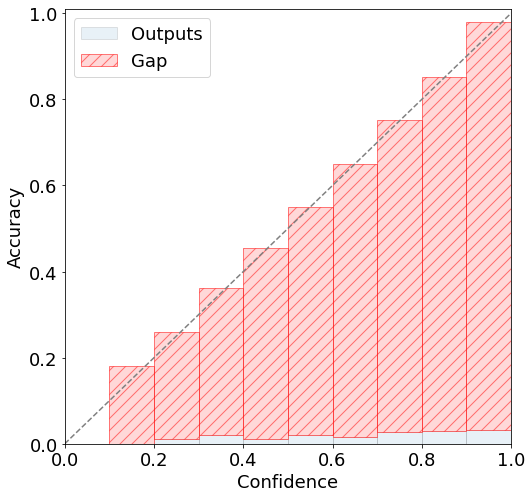

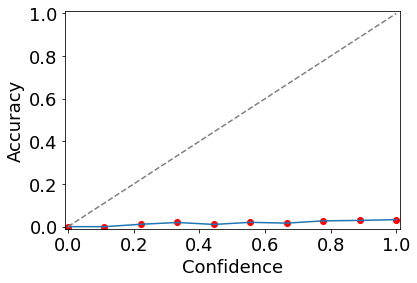

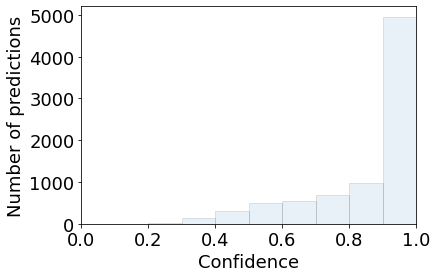

Overall accuracy: 2.82 %
Expected Calibration Error: 0.79
Maximum Calibration Error: 0.94


In [52]:
# Compute and visualize the calibration using the rotated dataset after temperature scaling.
makeModelDiagrams(logits_list, labels_list)

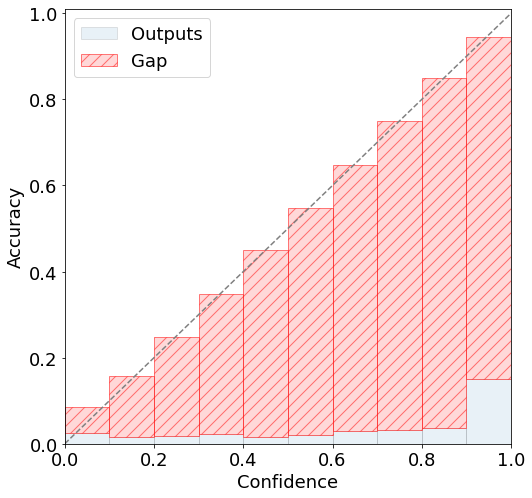

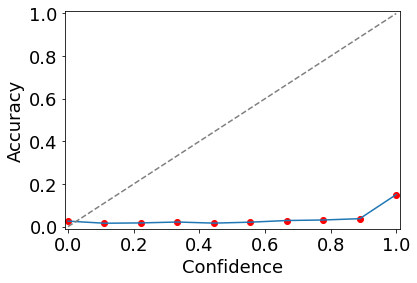

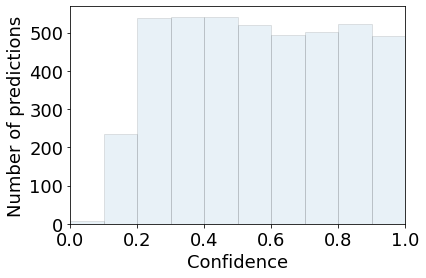

Overall accuracy: 2.82 %
Expected Calibration Error: 0.41
Maximum Calibration Error: 0.81


In [53]:
# Compute and visualize calibration using rotated dataset after tempreture scaling.
makeModelDiagrams(T_scaling(logits_list, temperature), labels_list)

# Other Calibration Methods

In fact, all post-hoc calibration methods can fail even under a mild shift of the input data [OFR+19]. Therefore, different calibration techniques should be utilized to tackle this issue. They can be categorized into Bayesian and non-Bayesian methods.
The first one learns a posterior distribution over parameters that quantifies parameter uncertainty, a type of epistemic uncertainty that can be reduced through the collection of additional data. On the other hand, the second group includes training multiple probabilistic NNs with  bootstraping or ensembling [OFR+19].

## Monte Carlo Dropout

*Monte Carlo dropout* is one of the most popular techniques, proposed by [Gal \& Ghahramani (2016)](https://arxiv.org/abs/1506.02142), to estimate uncertainty by combining the predictive distribution with the Bayesian neural network [awsb]. The idea is to interpret the regular dropout as a Bayesian approximation of the Gaussian process. In particular, a network with different dropped out neurons can be considered as Monte Carlo samples from the space of all available models [Ole]. The implementation of this technique is fairly straightforward; after a model is trained, a dropout should be applied at a test time. Thus, a network produces multiple predictions for each input. To yield a predicted class, these predictions can be either averaged or their distributions can be analyzed.

## Deep Ensembles

*Deep ensembles* are state-of-the-art methods in out-of-distribution settings [awsa]. In particular, they outperform Monte Carlo dropout and other methods [OFR+19]. The reason behind this is that their weight values and loss trajectories are very different from one another, which leads to diverse predictions [FHL20]. Therefore, just a few independently trained neural networks from the ensemble tend to recover the true predictive distribution more accurately compared to other methods [OFR+19]. 

# Possibilities of Extensions


One possibility to enrich this study would be the implementation of the two calibration methods, namely, *Monte Carlo dropout* and *deep ensembles*, as well as the inclusion of experiments based on those.

# Conclusion

In summery, this work explores the various aspects concerning the calibration of NNs.
Firstly, we define the notion of calibration as well as the related concepts of accuracy and confidence. We then give an intuitive explaination for the importance of calibration. It is futher explained why NNs are expected to return reliable confidence values and the reasons why this assumption might not hold. Next, we describe techniques to measure the calibration of a NN and consider approaches for improving this characteristic.

Moreover, we implement *ECE*, *MCE*, reliability diagrams and temperature scaling. Afterwards, we measure the calibration error of ResNet-101 trained on Cifar-100 before and after applying temperature scaling. As expected, our model shows an initial overconfidence. However, this issue is resolved after the application of temperature scaling. Finally, we investigate the performance of temperature scaling with data shifts, which proves to be ineffective in this case. In our opinion, this limits the application of temperature scaling as a calibration method in real-life applications, since it is hard to find scenarios that exclude out-of-distribution data.

# References

[awsa] &nbsp; &nbsp; &nbsp; &nbsp;Deep ensembles.&nbsp; &nbsp; &nbsp; &nbsp;https://docs.aws.amazon.com/prescriptive-guidance/latestml-quantifying-uncertainty/deep-ensembles.html. 
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; Accessed:  2021-09-10.

[awsb] &nbsp; &nbsp; &nbsp; &nbsp; Monte   Carlo   dropout.
&nbsp; &nbsp; &nbsp; &nbsp;https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/mc-dropout.html. 
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; Accessed:  2021-09-10.

[awsc]&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;Temperaturescaling.
&nbsp; &nbsp; &nbsp; &nbsp;https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/temp-scaling.html. 
&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; Accessed:  2021-09-10.

[FHL20]&nbsp; &nbsp; &nbsp; &nbsp;Stanislav Fort, Huiyi Hu, and Balaji Lakshminarayanan. Deep ensembles: A loss landscapeperspective, 2020.

[GPSW17]  &nbsp; &nbsp;Chuan Guo,
Geoff Pleiss, Yu Sun, and Kilian Q. Weinberger.  On calibration of modernneural networks, 2017.

[Kri]&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Alex Krizhevsky. The CIFAR-100 dataset.https://www.cs.toronto.edu/~kriz/cifar.html.  Accessed:  2021-09-07.

[OFR+19]  &nbsp; &nbsp; Yaniv  Ovadia,  Emily  Fertig,  Jie  Ren,  Zachary  Nado,  D  Sculley,  Sebastian  Nowozin,Joshua V. Dillon, Balaji Lakshminarayanan, and &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Jasper Snoek. Can you trust your model’suncertainty?  evaluating predictive uncertainty under dataset shift, 2019.

[Ole]&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; Micha l   Oleszak.Monte   Carlo   dropout.https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571.  Accessed:  2021-09-10